# Research Replication: Unsupervised Learning of Digit Recognition Using STDP (Part 1)

Let's apply what we have learned throughout these notebooks to an actual problem. We are going to focus on using the constructs we have built (adaptive LIF neurons, STDP, generating Poisson spike trains, etc.) to replicate the results of [a research paper from 2015](https://www.frontiersin.org/articles/10.3389/fncom.2015.00099/full){cite}`diehl2015unsupervised`. The goal of this paper is to classify handwritten digits using only SNN primitives. Specifically, we will use the (pervasive) [MNIST database](https://en.wikipedia.org/wiki/MNIST_database) of handwritten digits to train and test our network. We will use STDP as the learning algorithm for our network to learn from examples.

## MNIST Dataset

Let's start by loading the dataset. There are two .zip files attached to this notebook ([train](../_static/datasets/train-14x14-chunked.zip) and [test](../_static/datasets/test-14x14-chunked.zip)). I wrote some code to load the data from these files.

In [2]:
import zipfile
import json
import itertools
import random
from myst_nb import glue

random.seed(0)

def dataGenerator(path):
    with zipfile.ZipFile(path) as train_zip:
        with train_zip.open('index.json') as index_file:
            idx_info = json.loads(index_file.read())
            files = idx_info['files']
            N = idx_info['N']
            i = 0
            
            for fname in files:
                with train_zip.open(fname) as f:
                    data = json.loads(f.read())
                    images = data['images']
                    labels = data['labels']
                    for img, label in zip(images, labels):
                        yield (img, label)
                        i += 1
                        if i >= N: break          

DIGIT_WIDTH  = 14
DIGIT_HEIGHT = 14
DIGIT_SIZE   = DIGIT_WIDTH * DIGIT_HEIGHT
glue("DIGIT_SIZE", DIGIT_SIZE, display=False)
glue("DIGIT_WIDTH", DIGIT_WIDTH, display=False)
glue("DIGIT_HEIGHT", DIGIT_HEIGHT, display=False)

# trainDataGenerator = dataGenerator('../_static/datasets/train-chunked.zip')
trainDataGenerator = dataGenerator('../_static/datasets/train-14x14-chunked.zip')

Each image is an array of {glue:}`DIGIT_SIZE`({glue:}`DIGIT_WIDTH` x {glue:}`DIGIT_HEIGHT`) numbers. Each number represents a pixel intensity between 0 (blank) and 255 (filled). Most values will be 0 (blank). Let's load an image at some random index.

In [23]:
randomImage, randomLabel = random.choice(list(itertools.islice(trainDataGenerator, 0, 100)))
print(randomImage)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 57, 8, 0, 0, 20, 62, 0, 0, 0, 0, 0, 0, 0, 16, 185, 63, 0, 0, 75, 157, 0, 0, 0, 0, 0, 0, 2, 109, 188, 19, 0, 4, 169, 108, 0, 0, 0, 0, 0, 0, 47, 196, 56, 0, 0, 56, 220, 49, 0, 0, 0, 0, 0, 5, 134, 109, 1, 0, 0, 127, 176, 12, 0, 0, 0, 0, 0, 70, 205, 24, 0, 0, 11, 208, 91, 0, 4, 6, 0, 0, 0, 77, 199, 40, 0, 0, 79, 228, 54, 34, 138, 41, 0, 0, 0, 40, 199, 222, 140, 123, 186, 240, 225, 190, 94, 3, 0, 0, 0, 0, 31, 132, 159, 159, 243, 202, 86, 25, 2, 0, 0, 0, 0, 0, 0, 0, 0, 11, 231, 109, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 173, 89, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 59, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


It's a little difficult to interpret this so let's chunk it into a ({glue:}`DIGIT_WIDTH` x {glue:}`DIGIT_HEIGHT`) 2D array and visualize the intensities:

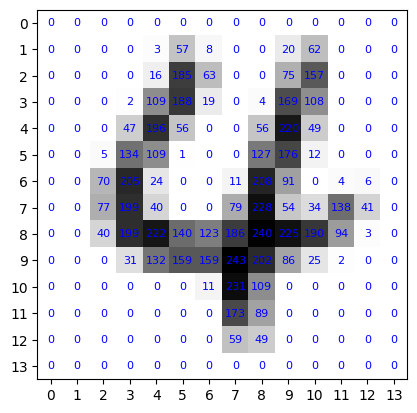

Label: 4


In [24]:

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)
digitPixels = np.reshape(np.array(randomImage), (DIGIT_WIDTH, DIGIT_HEIGHT))


plt.figure()
plt.imshow(digitPixels, cmap='gray_r')
plt.axis('on')
for i in range(digitPixels.shape[0]):
    for j in range(digitPixels.shape[1]):
        plt.text(j, i, int(digitPixels[i, j]), color='blue', fontsize=8, ha='center', va='center')

# Setting the ticks to show every number on both axes
plt.xticks(np.arange(0, DIGIT_WIDTH, 1))
plt.yticks(np.arange(0, DIGIT_HEIGHT, 1))

plt.show()

print('Label:', randomLabel)

We're going to train an SNN that can recognize these digits (given pixel intensities, try to find the correct label). First, we need to convert these pixel intensities into spike trains. We will use [the same method of Poisson spike train generation that we wrote in the previous notebook](11%20-%20Representing%202D%20Images.ipynb).

In [5]:
import numpy as np

def poisson_fire(values, min_value=0, max_value=255, min_rate=0, max_rate=10, dt=0.001):
    relativeValues = (values - min_value) / (max_value - min_value)
    relativeRates = min_rate + relativeValues * (max_rate - min_rate)
    probsOfFire = relativeRates * dt

    firings = np.random.rand(*values.shape) < probsOfFire
    return firings / dt

This will fire a spike at a rate proportional to the pixel intensity. We will use this spike train as the input to our network.

:::{image-spikes}
:width: 14
:height: 14
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 57, 125, 209, 214, 175, 66, 19, 0, 0, 0, 23, 1, 0, 51, 220, 250, 245, 228, 249, 239, 108, 0, 0, 0, 20, 1, 0, 12, 98, 138, 160, 217, 245, 189, 33, 0, 0, 0, 0, 0, 0, 4, 62, 187, 247, 227, 134, 37, 0, 0, 0, 0, 0, 0, 0, 27, 222, 253, 212, 38, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 42, 78, 216, 209, 53, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 27, 163, 189, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 113, 208, 28, 0, 0, 0, 0, 0, 39, 174, 84, 37, 106, 146, 229, 155, 11, 0, 0, 0, 0, 0, 62, 230, 220, 219, 246, 223, 152, 32, 0, 0, 0, 0, 0, 0, 3, 114, 211, 153, 86, 32, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
:::

We will use a decaying post-synaptic potential function, as implemented in [a previous notebook](./13%20-%20Neuron%20Collections.ipynb) connected to the input.

In [6]:
class SynapseCollection:
    def __init__(self, n=1, tau_s=0.05, t_step=0.001):
        self.n = n
        self.a = np.exp(-t_step / tau_s)  # Decay factor for synaptic current
        self.b = 1 - self.a  # Scale factor for input current

        self.voltage = np.zeros(n)  # Initial voltage of neurons
    
    def step(self, inputs):
        self.voltage = self.a * self.voltage + self.b * inputs

        return self.voltage

In [7]:
t_step = 0.001
synapses = SynapseCollection(n=len(randomImage), tau_s=0.1, t_step=t_step)

def step1(inp):
    input_spikes = poisson_fire(np.array(inp), dt=t_step, min_rate=0.1, max_rate=100)
    return input_spikes, synapses.step(input_spikes)

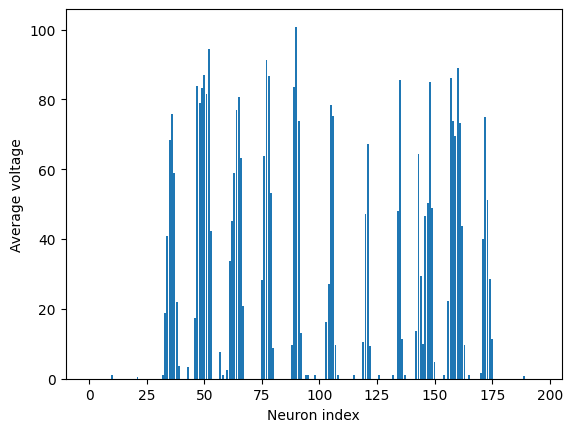

In [8]:
import matplotlib.pyplot as plt

voltages_over_time = []
T = 1 # second
for _ in np.arange(0, T, t_step):
    spikes, psp_voltages = step1(randomImage)
    voltages_over_time.append(psp_voltages)

average_values = np.mean(voltages_over_time, axis=0)

plt.figure()
# plt.bar(average_values)
plt.bar(np.arange(len(average_values)), average_values)
plt.xlabel('Neuron index')
plt.ylabel('Average voltage')
plt.show()

If we lay this out in a grid, we can visualize the spike train as a series of spikes at different intensities. It's going to look like our input image.

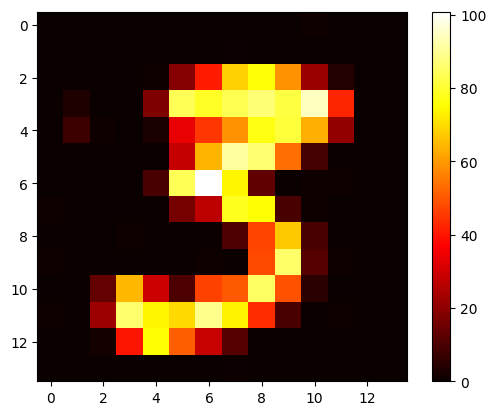

In [9]:
# plot in a 14x14 grid
plt.figure()
plt.imshow(average_values.reshape(14, 14), cmap='hot')
plt.colorbar()
plt.show()

The input to our network is going to be a random digit (like the one above) from the training set "displayed" to the network for some time (0.35 seconds), followed by a blank image for some time (0.15 seconds), and then repeating with the next image for every image in our training set.
<!-- We defined [a `DigitInput` class](https://observablehq.com/d/01f7c541e3f547f2?collection=@soney/neuromorphic-computing#DigitInput) to represent the digit input (you do not need to read the code). It follows from our previous code on representing numbers but has some more logic for changing the digits over time. -->


In [10]:
TIME_TO_SHOW_IMAGES = 0.35 # seconds
TIME_TO_SHOW_BLANK  = 0.15 # seconds

In [11]:
NUM_IMAGES = 100

for _ in range(NUM_IMAGES):
    current_image, label = next(trainDataGenerator)

    for _ in np.arange(0, TIME_TO_SHOW_IMAGES, t_step):
        step1(np.array(current_image))
    for _ in np.arange(0, TIME_TO_SHOW_BLANK, t_step):
        step1(np.zeros(len(current_image)))

We'll then connect this input to a layer of [Adaptive LIF neurons](./15%20-%20Adaptive%20LIF%20Neurons.ipynb) (which we'll call `excitatory_neurons`). We will use [STDP](./16%20-%20STDP.ipynb) to determine the weights between the input and the neurons.

In [12]:
class STDPWeights:
    def __init__(self, numPre, numPost, tau_plus = 0.03, tau_minus = 0.03, a_plus = 0.1, a_minus = 0.11, g_min=0, g_max=1):
        self.numPre = numPre
        self.numPost = numPost
        self.tau_plus = tau_plus
        self.tau_minus = tau_minus
        self.a_plus = a_plus
        self.a_minus = a_minus
        self.x = np.zeros(numPre)
        self.y = np.zeros(numPost)

        self.g_min = g_min
        self.g_max = g_max
        self.w = np.random.uniform(g_min, g_max, (numPre, numPost)) / numPost # Initialize weights


    def step(self, t_step):
        self.x = self.x * np.exp(-t_step/self.tau_plus)
        self.y = self.y * np.exp(-t_step/self.tau_minus)

    def updateWeights(self, preOutputs, postOutputs):
        self.x += (preOutputs  > 0) * self.a_plus
        self.y -= (postOutputs > 0) * self.a_minus

        alpha_g = self.g_max - self.g_min # Scaling factor for weight updates

        preSpikeIndices = np.where(preOutputs > 0)[0]   # Indices of pre-synaptic   spiking neurons
        postSpikeIndices = np.where(postOutputs > 0)[0]

        for ps_idx in preSpikeIndices:
            self.w[ps_idx] += alpha_g * self.y
            self.w[ps_idx] = np.clip(self.w[ps_idx], self.g_min, self.g_max)

        for ps_idx in postSpikeIndices:
            self.w[:, ps_idx] += alpha_g * self.x
            self.w[:, ps_idx] = np.clip(self.w[:, ps_idx], self.g_min, self.g_max)

class LIF:
    def __init__(self, n=1, dim=1, tau_rc=0.02, tau_ref=0.002, v_th=1, 
                 max_rates=[200, 400], intercept_range=[-1, 1], t_step=0.001, v_init = 0):
        self.n = n
        # Set neuron parameters
        self.dim = dim  # Dimensionality of the input
        self.tau_rc = tau_rc  # Membrane time constant
        self.tau_ref = tau_ref  # Refractory period
        self.v_th = np.ones(n) * v_th  # Threshold voltage for spiking
        self.t_step = t_step  # Time step for simulation
        
        # Initialize state variables
        # self.voltage = np.ones(n) * v_init  # Initial voltage of neurons
        self.voltage = np.random.uniform(0, 1, n)  # Initial voltage of neurons
        self.refractory_time = np.zeros(n)  # Time remaining in refractory period
        self.output = np.zeros(n)  # Output spikes

        # Generate random max rates and intercepts within the given range
        max_rates_tensor = np.random.uniform(max_rates[0], max_rates[1], n)
        intercepts_tensor = np.random.uniform(intercept_range[0], intercept_range[1], n)

        # Calculate gain and bias for each neuron
        # self.gain = self.v_th * (1 - 1 / (1 - np.exp((self.tau_ref - 1/max_rates_tensor) / self.tau_rc))) / (intercepts_tensor - 1)
        # self.bias = np.expand_dims(self.v_th - self.gain * intercepts_tensor, axis=1)
        self.gain = np.ones(n)
        self.bias = np.zeros(n)
        
        # Initialize random encoders
        # self.encoders = np.random.randn(n, self.dim)
        # self.encoders /= np.linalg.norm(self.encoders, axis=1)[:, np.newaxis]
        self.encoders = np.ones((n, self.dim))

    def reset(self):
        # Reset the state variables to initial conditions
        self.voltage = np.zeros(self.n)
        self.refractory_time = np.zeros(self.n)
        self.output = np.zeros(self.n)

    def step(self, inputs):
        dt = self.t_step  # Time step

        # Update refractory time
        self.refractory_time -= dt
        delta_t = np.clip(dt - self.refractory_time, 0, dt) # ensure between 0 and dt

        # Calculate input current
        I = np.sum(self.bias + inputs * self.encoders * self.gain[:, np.newaxis], axis=0) / self.n

        # Update membrane potential
        self.voltage = I + (self.voltage - I) * np.exp(-delta_t / self.tau_rc)

        # Determine which neurons spike
        spike_mask = self.voltage > self.v_th
        self.output[:] = spike_mask / dt  # Record spikes in output

        # Calculate the time of the spike
        t_spike = self.tau_rc * np.log((self.voltage[spike_mask] - I[spike_mask]) / (self.v_th[spike_mask] - I[spike_mask])) + dt

        # Reset voltage of spiking neurons
        self.voltage[spike_mask] = 0

        # Set refractory time for spiking neurons
        self.refractory_time[spike_mask] = self.tau_ref + t_spike

        return self.output  # Return the output spikes

class ALIF:
    def __init__(self, n=1, dim=1, tau_rc=0.02, tau_ref=0.002, v_th=1, 
                 max_rates=[200, 400], intercept_range=[-1, 1], t_step=0.001, v_init = 0,
                 tau_inh=0.05, inc_inh=1.0 # <--- ADDED
                 ):
        self.n = n
        # Set neuron parameters
        self.dim = dim  # Dimensionality of the input
        self.tau_rc = tau_rc  # Membrane time constant
        self.tau_ref = tau_ref  # Refractory period
        self.v_th = np.ones(n) * v_th  # Threshold voltage for spiking
        self.t_step = t_step  # Time step for simulation

        self.inh = np.zeros(n)  # <--- ADDED
        self.tau_inh = tau_inh  # <--- ADDED
        self.inc_inh = inc_inh  # <--- ADDED
        
        # Initialize state variables
        # self.voltage = np.ones(n) * v_init  # Initial voltage of neurons
        self.voltage = np.random.uniform(0, 1, n)  # Initial voltage of neurons
        self.refractory_time = np.zeros(n)  # Time remaining in refractory period
        self.output = np.zeros(n)  # Output spikes

        # Generate random max rates and intercepts within the given range
        max_rates_tensor = np.random.uniform(max_rates[0], max_rates[1], n)
        intercepts_tensor = np.random.uniform(intercept_range[0], intercept_range[1], n)

        # Calculate gain and bias for each neuron
        # self.gain = self.v_th * (1 - 1 / (1 - np.exp((self.tau_ref - 1/max_rates_tensor) / self.tau_rc))) / (intercepts_tensor - 1)
        # self.bias = np.expand_dims(self.v_th - self.gain * intercepts_tensor, axis=1)
        self.gain = np.ones(n)
        self.bias = np.zeros(n)
        
        # Initialize random encoders
        # self.encoders = np.random.randn(n, self.dim)
        # self.encoders /= np.linalg.norm(self.encoders, axis=1)[:, np.newaxis]
        self.encoders = np.ones((n, self.dim))

    def reset(self):
        # Reset the state variables to initial conditions
        self.voltage = np.zeros(self.n)
        self.refractory_time = np.zeros(self.n)
        self.output = np.zeros(self.n)
        self.inh = np.zeros(self.n)  # <--- ADDED

    def step(self, inputs):
        dt = self.t_step  # Time step

        # Update refractory time
        self.refractory_time -= dt
        delta_t = np.clip(dt - self.refractory_time, 0, dt) # ensure between 0 and dt

        # Calculate input current
        I = np.sum(self.bias + inputs * self.encoders * self.gain[:, np.newaxis], axis=0) / self.n

        # Update membrane potential
        self.voltage = I + (self.voltage - I) * np.exp(-delta_t / self.tau_rc)

        # Determine which neurons spike
        spike_mask = self.voltage > self.v_th + self.inh  # <--- ADDED + self.inh
        self.output[:] = spike_mask / dt  # Record spikes in output

        # Calculate the time of the spike
        t_spike = self.tau_rc * np.log((self.voltage[spike_mask] - I[spike_mask]) / (self.v_th[spike_mask] - I[spike_mask])) + dt

        # Reset voltage of spiking neurons
        self.voltage[spike_mask] = 0

        # Set refractory time for spiking neurons
        self.refractory_time[spike_mask] = self.tau_ref + t_spike

        self.inh = self.inh * np.exp(-dt / self.tau_inh) + self.inc_inh * (self.output > 0)  # <--- ADDED

        return self.output  # Return the output spikes

In [13]:
NUM_EXCITATORY = 16

In [14]:
stdp = STDPWeights(numPre=DIGIT_SIZE, numPost=NUM_EXCITATORY)
excitatory_neurons = ALIF(n=NUM_EXCITATORY, t_step=t_step)
excitatory_psp     = SynapseCollection(n=NUM_EXCITATORY, t_step=t_step, tau_s=0.2)

def step2(inp):
    input_spikes = poisson_fire(np.array(inp), dt=t_step, min_rate=0.1, max_rate=100)
    excitatory_inp = synapses.step(input_spikes)

    stdp.step(t_step)
    stdp.updateWeights(input_spikes, excitatory_neurons.output)

    excitatory_inp = inp @ stdp.w
    excitatory_spikes = excitatory_neurons.step(excitatory_inp)
    excitatory_outp = excitatory_psp.step(excitatory_spikes)


step2(randomImage)

Our goal is going to be to have each excitatory neuron associated with each digit. In order to do that, we want:

1. To ensure that none of the neurons get too "greedy" and start firing with every input. For that reason, we implement the excitatory layer with ALIFs, which become less sensitive after they start firing.
2. To try to encourage *one* neuron to be associated with each digit (we don't want every neuron to represent a `6`). When a digit is shown, we want to only encourage one neuron to respond. To do this, we add an extra **inhibitory** layer.

The inhibitory layer is a layer of LIF neurons (the same number of neurons as the excitatory layer). Each excitatory neuron has *one* corresponding inhibitory neuron. But, each inhibitory neuron will inhibit **every other excitatory neuron**. So, when an excitatory *x* neuron fires, it triggers its associated inhibitory neuron to fire. When that inhibitory neuron fires, it inhibits every excitatory neuron *except* for *x*, making it more likely that *x* is the only excitatory neuron that fires.

In [15]:
inhibitory_neurons = LIF(n=NUM_EXCITATORY, t_step=t_step)
inhibitory_psp     = SynapseCollection(n=NUM_EXCITATORY, t_step=t_step, tau_s=0.2)
inhibitory_outp    = np.zeros(NUM_EXCITATORY)

def step3(inp):
    global inhibitory_outp
    input_spikes = poisson_fire(np.array(inp), dt=t_step, min_rate=0.1, max_rate=100)
    excitatory_inp = synapses.step(input_spikes)

    stdp.step(t_step)
    stdp.updateWeights(input_spikes, excitatory_neurons.output)

    excitatory_inp = excitatory_inp @ stdp.w + inhibitory_outp * -1
    excitatory_spikes = excitatory_neurons.step(excitatory_inp)
    excitatory_outp = excitatory_psp.step(excitatory_spikes)

    inhibitory_spikes = inhibitory_neurons.step(excitatory_outp)
    raw_inhibitory_outp   = inhibitory_psp.step(inhibitory_spikes)
    total_inhibiry_outp = np.sum(raw_inhibitory_outp)
    inhibitory_outp = total_inhibiry_outp * np.ones(NUM_EXCITATORY) - raw_inhibitory_outp

step3(randomImage)

![](../_static/images/mnist_stdp.png)

In order make sure that *some* neuron is responding, we also specify that we can only advance to the next digit if at least *5* excitatory neurons have fired while showing the digit. If not, then we increase the digit's intensity (by upping the maximum firing rate and showing that digit for longer).

<!-- You can see our network running below. At the top is the input. Below that is a grid representing all excitatory neurons. Inside each neuron display is the *weights* associated with each input. -->

In [16]:
t_step = 0.002  # Time step for the simulation
synapses = SynapseCollection(n=DIGIT_SIZE, tau_s=0.1, t_step=t_step)  # Synapse collection for input connections

# STDP (Spike-Timing-Dependent Plasticity) weight matrix between input and excitatory neurons
stdp = STDPWeights(numPre=DIGIT_SIZE, numPost=NUM_EXCITATORY, g_min=-0.1, g_max=1.1)

# Inhibitory neurons and their corresponding post-synaptic potential (PSP) collection
inhibitory_neurons = LIF(n=NUM_EXCITATORY, t_step=t_step)
inhibitory_psp = SynapseCollection(n=NUM_EXCITATORY, t_step=t_step, tau_s=0.5)
inhibitory_outp = np.zeros(NUM_EXCITATORY)  # Initialize inhibitory output array

# Excitatory neurons and their corresponding PSP collection
excitatory_neurons = ALIF(n=NUM_EXCITATORY, t_step=t_step, tau_inh=1.1)
excitatory_psp = SynapseCollection(n=NUM_EXCITATORY, t_step=t_step, tau_s=0.2)

# Function to perform a simulation step
def step(inp, max_input_rate):
    global inhibitory_outp
    input_spikes = poisson_fire(np.array(inp), dt=t_step, min_rate=0.01, max_rate=max_input_rate)  # Generate input spikes
    input_psp = synapses.step(input_spikes)  # Step the input synapses to get PSP

    stdp.step(t_step)  # Step the STDP mechanism
    stdp.updateWeights(input_spikes, excitatory_neurons.output)  # Update weights based on input and output spikes

    excitatory_inp = input_psp @ stdp.w + np.clip(inhibitory_outp * -1, a_max=0, a_min=None)  # Calculate excitatory input combining synapse output and inhibitory output
    excitatory_spikes = excitatory_neurons.step(excitatory_inp)  # Step excitatory neurons to get their spikes

    excitatory_outp = excitatory_psp.step(excitatory_spikes)  # Update the excitatory post-synaptic potential

    inhibitory_spikes = inhibitory_neurons.step(excitatory_outp)  # Step inhibitory neurons using excitatory output
    # print(input_psp@stdp.w, excitatory_inp, excitatory_spikes, excitatory_outp, inhibitory_spikes)
    raw_inhibitory_outp = inhibitory_psp.step(inhibitory_spikes)  # Update the inhibitory post-synaptic potential
    total_inhibitory_outp = np.sum(raw_inhibitory_outp)  # Calculate the total inhibitory output
    inhibitory_outp = total_inhibitory_outp * np.ones(NUM_EXCITATORY) - raw_inhibitory_outp  # Calculate the inhibitory output for each neuron

    num_fires = np.sum(excitatory_spikes > 0)  # Count the number of excitatory neurons that fired
    return num_fires

def run_simulation(num_images=1):
    for _ in range(num_images):
        current_image, label = next(trainDataGenerator)  # Get the next image and label from the data generator

        total_fires = 0  # Initialize the total number of fires
        max_input_rate = 0.5  # Initial maximum input firing rate

        while total_fires < 5:
            for _ in np.arange(0, TIME_TO_SHOW_IMAGES, t_step):  # Display the image for a set duration
                num_fires = step(np.array(current_image), max_input_rate=max_input_rate)  # Perform a simulation step
                total_fires += num_fires  # Accumulate the number of fires
                if total_fires >= 5: break  # Break if the total number of fires is reached (this is different from the original paper but helps run the simulation faster)
            max_input_rate *= 1.1  # Increase the input firing rate

        for _ in np.arange(0, TIME_TO_SHOW_BLANK, t_step):  # Show a blank input for a set duration
            step(np.zeros(len(current_image)), max_input_rate=max_input_rate)  # Perform a simulation step with blank input

def plotWeights():
    NUM_DISPLAY_ROWS = 4
    NUM_DISPLAY_COLS = 4

    plt.figure()

    for i in range(NUM_EXCITATORY):
        plt.subplot(NUM_DISPLAY_ROWS, NUM_DISPLAY_COLS, i+1)
        plt.imshow(stdp.w[:, i].reshape(DIGIT_WIDTH, DIGIT_HEIGHT), cmap='gray')
        plt.axis('off')
    plt.show()

Randomly initialized weights


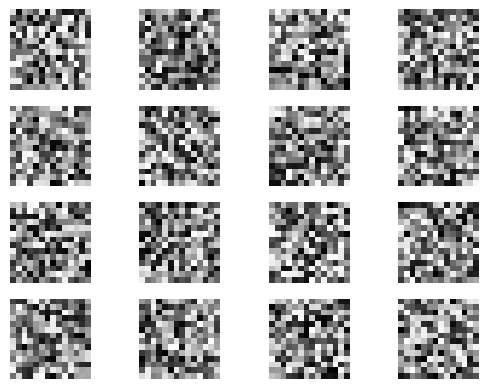

Run simulation for 100 images


/tmp/ipykernel_3520133/2666458793.py:167: RuntimeWarning: invalid value encountered in log
  t_spike = self.tau_rc * np.log((self.voltage[spike_mask] - I[spike_mask]) / (self.v_th[spike_mask] - I[spike_mask])) + dt


Updated weights


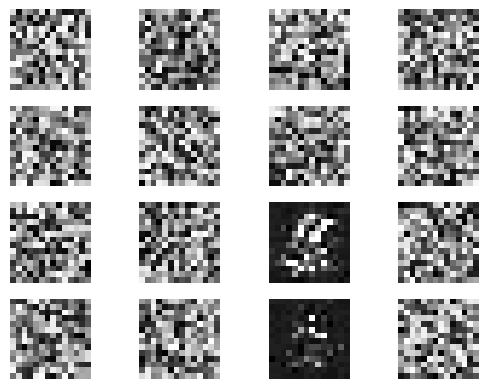

Run simulation for 1000 images
Updated weights


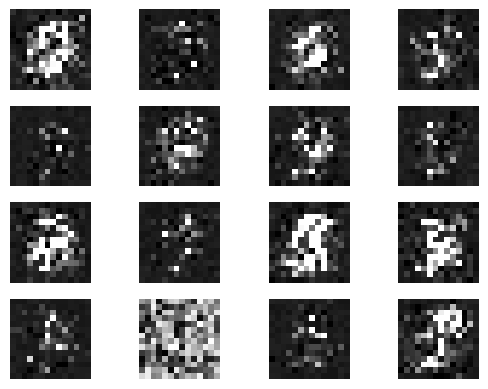

In [17]:
print("Randomly initialized weights"); plotWeights()

for n in [100, 1000]:
    print(f"Run simulation for {n} images"); run_simulation(num_images=n); print("Updated weights"); plotWeights()

It takes a while but if you run the simulation for long enough, you can start to see the "imprint" of the input appearing on the weights for a given neuron. Note that we've scaled down this example (both the inputs and the number of neurons) so the digits might not be as clear as they would be in a full simulation. It also takes a long time to train, so the weights will be incomplete. However, in the next notebook, we will pre-supply a larger model and execute it.

This notebook (mostly) follows the paper: Diehl, Peter U., and Matthew Cook. "Unsupervised learning of digit recognition using spike-timing-dependent plasticity." {cite}`diehl2015unsupervised` but there are some differences.

In the paper, there is an additional labeling step (where we analyze each neuron to determine which digit it represents) and testing step (to determine the accuracy). With 6,400 neurons (rather than our 100) and 28 x 28 inputs (rather than our 14 x 14), they achieve an accuracy of 95%. However, we are going to skip these steps (implementation is similar to what we did above) and stick to a smaller network that can run more quickly.

## Summary

- We created a network that can recognize digits from the MNIST dataset
- Our network uses primitives that we learned in prior notebooks: LIFs, ALIFs, STDP, and PSPs
- The STDP weights, which we learn over time, encode the digits being recognized
- Our network is a scaled down version of the one implemented by Diehl and Cook {cite}`diehl2015unsupervised`


:::{bibliography}
:filter: docname in docnames
:::